In [71]:
%%capture 
!pip install -r requirements.txt

In [72]:
import torch
import numpy as np
torch.manual_seed(7777)
np.random.seed(7777)

device = torch.device('cpu')

# print('Training will be done on the ' + 'GPU' if torch.cuda.is_available() else 'CPU')

In [73]:
from enum import Enum, StrEnum

class Scaling(Enum):
    INDEPENDENT = 1
    JOINT = 2

class DatasetType(StrEnum):
    TRAIN = 'trn'
    TEST = 'tst'
    VALIDATION = 'trn'

# Global variable to enable debug mode
DEBUG = True

#### Data loading & pre-processing functions

In [74]:
import pandas as pd
import numpy as np
from sklearn import preprocessing


# *Helper function to preprocess the RSSI data
@DeprecationWarning
def preprocess_rssi_data(df_rssi: pd.DataFrame, scaling_strategy: Scaling) -> pd.DataFrame:
    """
    This function preprocesses the training data by:
    1. Replacing all 100 values with -110 (ensures continuity of data)
    2. Separating the RSS values from the labels
    3. Scaling the data to have zero mean and unit variance

    Parameters:
    - train: The training data to be preprocessed
    - scaling_strategy: The scaling strategy to be used (INDEPENDENT or JOINT)
    """
    
    # 1. replace all 100 values with -110 (ensures continuity of data)
    df = df_rssi.replace(100, -110)
    
    # 2. Separate the RSS values from the labels
    rssiValues = df.iloc[:, :-3]
    labels = df.iloc[:, -3:]
    
    # 3. Scale the data to have zero mean and unit variance
    # This is done either independently for each AP or jointly for all APs
    if scaling_strategy == Scaling.INDEPENDENT:
        scaler = preprocessing.StandardScaler()

        scaled_rss = scaler.fit_transform(rssiValues)
        df_scaled_rss = pd.DataFrame(scaled_rss, columns=rssiValues.columns)
        df = pd.concat([df_scaled_rss, labels], axis=1)
    
    elif scaling_strategy == Scaling.JOINT:
        flattened = rssiValues.values.flatten()
        global_mean = np.mean(flattened)
        global_std = np.std(flattened)
        
        scaled_rss = (rssiValues - global_mean) / global_std
        df = pd.concat([scaled_rss, labels], axis=1)
        df = df.reset_index(drop=True)
    
    else: 
        raise NotImplementedError("Specified scaling strategy is not implemented, use either Scaling.INDEPENDENT or Scaling.JOINT.")
    
    return df

# *Load and pre-process the data\
@DeprecationWarning
def get_preprocessed_dataset(data_path: str, months: list[str], sets: list[str], type: DatasetType, num_APs: int, scaling_strategy: Scaling, floor: int) -> pd.DataFrame:
    """
    This function loads and preprocesses the training data from the specified training months and floor.

    Parameters:
    - data_path: The path to the data
    - months: The list of months to be used
    - sets: The list of set numbers to be used
    - type: The type of dataset to be made (TRAIN, TEST or VALIDATION)
    - num_APs: The number of access points
    - scaling_strategy: The scaling strategy to be used (INDEPENDENT or JOINT)
    - floor: The floor to be used
    """
    pass
    # # Since the csv files do not have column names, we define these first.
    # list_of_APs = ["AP" + str(i) for i in range(0, num_APs)]

    # # Load the test data from all specified test sets.  
    # df_test_rss = pd.concat([pd.read_csv(data_path + month + '/' + type + set + 'rss.csv', names=list_of_APs) for month in months for set in sets])
    # df_test_rss = df_test_rss.reset_index(drop=True)
    
    # # Get all x,y,floor labels
    # df_test_labels = pd.concat([pd.read_csv(data_path + month + '/' + type + set + 'crd.csv', names=['x', 'y', 'floor']) for month in months for set in sets])
    # df_test_labels = df_test_labels.reset_index(drop=True)

    # # Add the labels to the pre-processed data
    # df_test_labeled = pd.concat([df_test_rss, df_test_labels], axis=1)
    
    # # Filter the data to only include the specified floor
    # df_test_labeled = df_test_labeled[df_test_labeled['floor'] == floor]

    # # Pre-processing of the training data
    # df_test = preprocess_rssi_data(df_test_labeled, scaling_strategy)
    
    # return df_test


# Let's do it differently, have two separate functions
# 1. Load a dataset based on a list of full paths, and return a df_{type}_x and df_{type}_y
# 2. Preprocess the dataset based on the df_{type}_x and df_{type}_y

def load_dataset(paths: list[str], num_APs: int, floor: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    # Since the csv files do not have column names, we define these first.
    list_of_APs = ["AP" + str(i) for i in range(0, num_APs)]
    
    # Load the data from all specified paths
    df_x = pd.concat([pd.read_csv(path + 'rss.csv', names=list_of_APs) for path in paths])
    df_x = df_x.reset_index(drop=True)
    
    # Get all x,y,floor labels
    df_y = pd.concat([pd.read_csv(path + 'crd.csv', names=['x', 'y', 'floor']) for path in paths])
    df_y = df_y.reset_index(drop=True)
    
    # Get indexes of the specified floor
    floor_indexes = df_y[df_y['floor'] == floor].index
    
    # Keep only the rows with the specified floor for both x and y, and reset the indexes
    df_x = df_x.loc[floor_indexes]
    df_x = df_x.reset_index(drop=True)
    
    # For df_y, also remove the floor column
    df_y = df_y.loc[floor_indexes]
    df_y = df_y.drop(columns=['floor'])
    df_y = df_y.reset_index(drop=True)
    
    return df_x, df_y

def preprocess_rssi(df_rssi: pd.DataFrame, scaling_strategy: Scaling):
    # Flattened dataset for easy searching
    flattened = df_rssi.values.flatten()
    
    # Minimum rssi found
    min_rssi = np.min(flattened)
    print("Minimum RSSI: ", min_rssi)
    
    # Find biggest multiple of 10 smaller than min_rssi
    replacement_rssi = np.floor((min_rssi - 1) / 10) * 10
    print("Replacement value", replacement_rssi)
    
    # Replace all 100 values with replacement_rssi
    df_rssi = df_rssi.replace(100, replacement_rssi)
    flattened = df_rssi.values.flatten() # Update flattened since we changed the dataframe
    
    # Standardization part
    if scaling_strategy == Scaling.INDEPENDENT: # Might not work
        scaler = preprocessing.StandardScaler()

        scaled_rss = scaler.fit_transform(df_rssi)
        df_scaled_rss = pd.DataFrame(scaled_rss, columns=df_rssi.columns)
        df_rssi = df_scaled_rss
    elif scaling_strategy == Scaling.JOINT:
        global_mean = np.mean(flattened)
        global_std = np.std(flattened)
        
        df_rssi = (df_rssi - global_mean) / global_std
    else:
        raise NotImplementedError("Specified scaling strategy is not implemented, use either Scaling.INDEPENDENT or Scaling.JOINT.")
    
    return df_rssi
    

#### SETUP

In [75]:
from sklearn.model_selection import train_test_split

data_paths = [
    './data/V1.0/01/trn01',
    './data/V1.0/02/trn01',
    './data/V1.0/03/trn01', 
    './data/V1.0/04/trn01',
    './data/V1.0/05/trn01',
    './data/V1.0/06/trn01',
    './data/V1.0/07/trn01',
    './data/V1.0/08/trn01',
    './data/V1.0/09/trn01',
    './data/V1.0/10/trn01',
    './data/V1.0/11/trn01',
    './data/V1.0/12/trn01',
    './data/V1.0/13/trn01',
    './data/V1.0/14/trn01',
    './data/V1.0/15/trn01',
]
num_APs = 448
scaling_strategy = Scaling.JOINT
floor = 3

# Split training data into 10% validation data
df_x, df_y = load_dataset(data_paths, num_APs, floor)

if DEBUG: print('df_x:', df_x.shape)
if DEBUG: print('df_y:', df_y.shape)

df_train_x, df_val_x, df_train_y, df_val_y = train_test_split(df_x, df_y, test_size=0.1, random_state=7777)

if DEBUG: print('df_train_x:', df_train_x.shape)
if DEBUG: print('df_train_y:', df_train_y.shape)
if DEBUG: print('df_val_x:', df_val_x.shape)
if DEBUG: print('df_val_y:', df_val_y.shape)

if DEBUG: print(df_train_x.head())
if DEBUG: print(df_train_y.head())


df_x: (4320, 448)
df_y: (4320, 2)
df_train_x: (3888, 448)
df_train_y: (3888, 2)
df_val_x: (432, 448)
df_val_y: (432, 2)
      AP0  AP1  AP2  AP3  AP4  AP5  AP6  AP7  AP8  AP9  ...  AP438  AP439  \
4053  100  100  100  100  100  -85  -61  -86  -60  100  ...    100    100   
963   100  -78  -68  100  100  100  -66  100  -80  -93  ...    100    100   
4039  100  100  100  100  100  100  -47  100  -43  -80  ...    100    100   
3523  100  100  100  100  100  100  -81  100  -85  100  ...    100    100   
1766  100  -77  -84  100  100  100  -81  100  -75  -86  ...    100    100   

      AP440  AP441  AP442  AP443  AP444  AP445  AP446  AP447  
4053    100    100    100    100    100    100    100    100  
963     100    100    100    100    100    100    100    100  
4039    100    100    100    100    100    100    100    100  
3523    100    100    100    100    100    100    100    100  
1766    100    100    100    100    100    100    100    100  

[5 rows x 448 columns]
              x

In [76]:
# Preprocess the data
df_train_x = preprocess_rssi(df_train_x, scaling_strategy)
df_val_x = preprocess_rssi(df_val_x, scaling_strategy)

if DEBUG: print(np.mean(df_train_x.values.flatten()))
if DEBUG: print(np.std(df_train_x.values.flatten()))

Minimum RSSI:  -98
Replacement value -100.0
Minimum RSSI:  -97
Replacement value -100.0
6.978871070431797e-17
0.9999999999999999


In [77]:
data_paths = [
    './data/V1.0/01/tst01', './data/V1.0/01/tst02', './data/V1.0/01/tst03',
    './data/V1.0/02/tst01', './data/V1.0/02/tst02', './data/V1.0/02/tst03',
    './data/V1.0/03/tst01', './data/V1.0/03/tst02', './data/V1.0/03/tst03',
    './data/V1.0/04/tst01', './data/V1.0/04/tst02', './data/V1.0/04/tst03',
    './data/V1.0/05/tst01', './data/V1.0/05/tst02', './data/V1.0/05/tst03',
    './data/V1.0/06/tst01', './data/V1.0/06/tst02', './data/V1.0/06/tst03',
    './data/V1.0/07/tst01', './data/V1.0/07/tst02', './data/V1.0/07/tst03',
    './data/V1.0/08/tst01', './data/V1.0/08/tst02', './data/V1.0/08/tst03',
    './data/V1.0/09/tst01', './data/V1.0/09/tst02', './data/V1.0/09/tst03',
    './data/V1.0/10/tst01', './data/V1.0/10/tst02', './data/V1.0/10/tst03',
    './data/V1.0/11/tst01', './data/V1.0/11/tst02', './data/V1.0/11/tst03',
    './data/V1.0/12/tst01', './data/V1.0/12/tst02', './data/V1.0/12/tst03',
    './data/V1.0/13/tst01', './data/V1.0/13/tst02', './data/V1.0/13/tst03',
    './data/V1.0/14/tst01', './data/V1.0/14/tst02', './data/V1.0/14/tst03',
    './data/V1.0/15/tst01', './data/V1.0/15/tst02', './data/V1.0/15/tst03',
]

df_test_x, df_test_y = load_dataset(data_paths, num_APs, floor)

# Standardize the test data
df_test_x = preprocess_rssi(df_test_x, scaling_strategy)

if DEBUG: print('df_test_x:', df_test_x.shape)
if DEBUG: print('df_test_y:', df_test_y.shape)

if DEBUG: print(np.mean(df_test_x.values.flatten()))
if DEBUG: print(np.std(df_test_x.values.flatten()))

Minimum RSSI:  -100
Replacement value -110.0
df_test_x: (12960, 448)
df_test_y: (12960, 2)
-6.698835098229902e-16
1.0000000000000002


In [78]:
# Dimensionality reduction using PCA (Principal Component Analysis)
from sklearn.decomposition import PCA

# Fit PCA on the training data
pca_128 = PCA(n_components=128)
pca_64 = PCA(n_components=64)

train_x_pca_128 = pca_128.fit_transform(df_train_x)
val_x_pca_128 = pca_128.transform(df_val_x)
test_x_pca_128 = pca_128.transform(df_test_x)

train_x_pca_64 = pca_64.fit_transform(df_train_x)
val_x_pca_64 = pca_64.transform(df_val_x)
test_x_pca_64 = pca_64.transform(df_test_x)

# PCA Statistics
if DEBUG: print('Explained variance (128):', np.sum(pca_128.explained_variance_ratio_))
if DEBUG: print('Explained variance (64):', np.sum(pca_64.explained_variance_ratio_))


Explained variance (128): 0.9986599579855944
Explained variance (64): 0.9649894518038313


In [79]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Since the implementations will be made in PyTorch, we convert the data to PyTorch tensors
X_train_tensor = torch.tensor(df_train_x.values, dtype=torch.float32)
X_train_128_tensor = torch.tensor(train_x_pca_128, dtype=torch.float32)
X_train_64_tensor = torch.tensor(train_x_pca_64, dtype=torch.float32)
y_train_tensor = torch.tensor(df_train_y.values, dtype=torch.float32)


X_test_tensor = torch.tensor(df_test_x.values, dtype=torch.float32)
X_test_128_tensor = torch.tensor(test_x_pca_128, dtype=torch.float32)
X_test_64_tensor = torch.tensor(test_x_pca_64, dtype=torch.float32)
y_test_tensor = torch.tensor(df_test_y.values, dtype=torch.float32)


X_val_tensor = torch.tensor(df_val_x.values, dtype=torch.float32)
X_val_128_tensor = torch.tensor(val_x_pca_128, dtype=torch.float32)
X_val_64_tensor = torch.tensor(val_x_pca_64, dtype=torch.float32)
y_val_tensor = torch.tensor(df_val_y.values, dtype=torch.float32)

# Get the data via DataLoaders
t_training = TensorDataset(X_train_tensor, y_train_tensor)
t_test = TensorDataset(X_test_tensor, y_test_tensor)
t_val = TensorDataset(X_val_tensor, y_val_tensor)

t_training_128 = TensorDataset(X_train_128_tensor, y_train_tensor)
t_test_128 = TensorDataset(X_test_128_tensor, y_test_tensor)
t_val_128 = TensorDataset(X_val_128_tensor, y_val_tensor)

t_training_64 = TensorDataset(X_train_64_tensor, y_train_tensor)
t_test_64 = TensorDataset(X_test_64_tensor, y_test_tensor)
t_val_64 = TensorDataset(X_val_64_tensor, y_val_tensor)

# train_loader = DataLoader(t_training, batch_size=16, shuffle=True)
# test_loader = DataLoader(t_test, batch_size=16, shuffle=True)
# val_loader = DataLoader(t_val, batch_size=16, shuffle=True)



# MultiLayer Perceptrons

#### Full-Input MLP
This network takes the full input of 448 features to perform x,y predictions.

In [80]:
import torch.nn as nn
import copy

class MLP(nn.Module):
    def __init__(self, hidden_layer_sizes, dropout_rate, input_dim=448):
        super(MLP, self).__init__()
        
        layers = []
        
        # Make it easier to grid-search different sizes of hidden layers
        for hidden_dim in hidden_layer_sizes:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_dim # Update input_dim for next layer
        
        # At this point we know input_dim equals the output size of the last hidden layer, so we can re-use it here.
        layers.append(nn.Linear(input_dim, 2)) # x,y output
        
        # Construct the actual model based on the layers defined above.
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)
    

def train_MLP(model, train_loader, val_loader, criterion, optimizer, epochs):
    
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Early stopping variables
    best_model_wts = None
    best_val_loss = np.inf
    epochs_without_improvement = 0
    epochs_to_use = 0
    patience = 10
    
    # Training/Validation loops
    for epoch in range(epochs):
        model.train() # Sets the model to training mode
        running_loss = 0.0 # Keep track of the (MSE) loss
        
        # Actual training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) 
            
            # Extra case for LGFBS
            def closure():
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    return loss
            
            if isinstance(optimizer, torch.optim.LBFGS):
                optimizer.step(closure)
                loss = closure()
            
            else:
                optimizer.zero_grad() # Reset gradients from last iteration
                outputs = model(inputs) # Forward pass
                loss = criterion(outputs, labels) # Compute the loss (MSE) between the predictions and the ground-truth labels
                loss.backward() # Perform backpropagation
                optimizer.step() # Update model parameters (weights) based on the gradients computed during backpropagation
            
            running_loss += loss.item() # Running loss is the sum of the losses for all batches FOR THE CURRENT EPOCH 
        
        # Validation time
        model.eval()
        val_loss = 0.0 # Accumulated validation loss
        
        # Validation loop
        with torch.no_grad(): # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device) # Move data to GPU if available
                
                outputs = model(inputs) # Forward pass to get predictions
                loss = criterion(outputs, labels) # Compute the loss (MSE) between the predictions and the ground-truth labels
                val_loss += loss.item() # Accumulate the validation loss for this epoch <-- TODO: (Make list for final model to plot)
        
        avg_val_loss = val_loss / len(val_loader)
        
        # Print the loss for this epoch
        print(f'Epoch {epoch+1}/{epochs} - Avg Training Loss: {running_loss/len(train_loader)} - Avg Validation Loss: {val_loss/len(val_loader)}')
    
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_to_use = epoch+1
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epoch+1} epochs without improvement. Use model from epoch {epochs_to_use}')
            break
    
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    
    print('Finished Training')
    return best_val_loss, model

#### Reduced-Input MLP
Using PCA instead now

#### Hyper-parameter tuning

In [81]:
import optuna

def MLP_full_optimize(trial, optim : str = 'Adam') -> float:
    # Hyper-parameters to be optimized
    # hidden_layer_size = trial.suggest_categorical('hidden_layer_size', [700, 512, 256, 128])
    hidden_layer_count = trial.suggest_int('hidden_layer_count', 2, 4) # inclusive
    hidden_layer_sizes = [trial.suggest_categorical(f'hidden_layer_size_{i}', [640, 576, 512, 448, 256, 128, 64, 32, 16]) for i in range(hidden_layer_count)]
    # hidden_layer_sizes = (hidden_layer_size,) * hidden_layer_count
    
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    lr = trial.suggest_float('lr', 0.001, 0.01)
    batch_size = trial.suggest_int('batch_size', 16, 512, step=16)
    epochs = trial.suggest_int('epochs', 50, 150)
    
    # Initialize the model
    model = MLP(hidden_layer_sizes, dropout_rate)
    
    if optim.lower() == 'adam': optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optim.lower() == 'lbfgs': optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
    else : raise ValueError('Unknown optimizer')
    
    criterion = nn.MSELoss()
    
    # Use chosen batch size instead of pre-defined one
    train_loader = DataLoader(t_training, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(t_val, batch_size=batch_size, shuffle=True)
    
    # Train the model, return validation loss
    val_loss, trained_model = train_MLP(model, train_loader, val_loader, criterion, optimizer, epochs)
    
    return val_loss, trained_model




def MLP_SAE_optimize(trial, t_training_pca, t_validation_pca, input_size, optim : str = 'Adam') -> float:
    # Hyper-parameters to be optimized
    
    # hidden_layer_size = trial.suggest_categorical('hidden_layer_size', [256, 128, 64, 32, 16])
    hidden_layer_count = trial.suggest_int('hidden_layer_count', 2, 4) # inclusive
    hidden_layer_sizes = [trial.suggest_categorical(f'hidden_layer_size_{i}', [640, 576, 512, 448, 256, 128, 64, 32, 16]) for i in range(hidden_layer_count)]
    
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    lr = trial.suggest_float('lr', 0.001, 0.01)
    batch_size = trial.suggest_int('batch_size', 16, 512, step=16)
    epochs = trial.suggest_int('epochs', 50, 150)
    
    # Initialize the model
    model = MLP(hidden_layer_sizes, dropout_rate, input_size)
    
    
    if optim.lower() == 'adam': optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optim.lower() == 'lbfgs': optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
    else : raise ValueError('Unknown optimizer')
    
    criterion = nn.MSELoss()
    
    # Use chosen batch size instead of pre-defined one
    
    
    train_loader = DataLoader(t_training_pca, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(t_validation_pca, batch_size=batch_size, shuffle=True)
    
    
    # Train the model, return validation loss
    val_loss, trained_model = train_MLP(model, train_loader, val_loader, criterion, optimizer, epochs)
    
    return val_loss, trained_model

In [82]:

# Use the following booleans to enable or disable the grid-search for the different models.
# After running the grid-search, train the final models with the best hyperparameters.

SEARCH_MLP_FULL = True
SEARCH_MLP_REDUCED_128 = True
SEARCH_MLP_REDUCED_64 = True

TRIALS_MLP = 20

In [83]:
%%capture MLP_opt_out

import optuna

def pretty_print_study(study):
    print('====================================')
    print('Number of finished trials:', len(study.trials))
    print('Best trial:')
    trial = study.best_trial
    print('     Trial Number: ', trial.number)
    print('     Duration: ', trial.duration.total_seconds())
    print('     Value: ', trial.value)
    print('     Params: ')
    for key, value in trial.params.items():
        print(f'         {key}: {value}')

def save_best_MLP(study, path, training_data, validation_data, input_size=448):
    best_trial = study.best_trial
    
    hidden_layer_sizes = [best_trial.params[f'hidden_layer_size_{i}'] for i in range(best_trial.params['hidden_layer_count'])]
    model = MLP(hidden_layer_sizes, best_trial.params['dropout_rate'], input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_trial.params['lr'])
    criterion = nn.MSELoss()
    
    
    train_loader = DataLoader(training_data, batch_size=best_trial.params['batch_size'], shuffle=True)
    val_loader = DataLoader(validation_data, batch_size=best_trial.params['batch_size'], shuffle=True)
    
    val_loss, trained_model = train_MLP(model, train_loader, val_loader, criterion, optimizer, best_trial.params['epochs'])
    
    torch.save(trained_model.state_dict(), path)

if SEARCH_MLP_FULL:
    print('Starting MLP full grid search')

    # Optuna study object and direction (minimize validation loss)
    study = optuna.create_study(direction='minimize')
    # study.optimize(MLP_full_gridsearch, n_trials=2)
    study.optimize(lambda trial: MLP_full_optimize(trial, 'Adam')[0], n_trials=TRIALS_MLP)

    pretty_print_study(study)

    # Save trained model from best trial
    best_trial = study.best_trial
    save_best_MLP(study, f'./models/MLP/full_MLP.pth', t_training, t_val, 448)
    
else: print('Skipping SEARCH_MLP_FULL')

print('\n====================================')
print('V results for SEARCH_MLP_REDUCED_128 V')
print('====================================\n')


if SEARCH_MLP_REDUCED_128:
    print('Starting MLP reduced grid search for 256-128 SAE')

    # encoders = train_stacked_autoencoders(X_train_tensor, 448, [256, 128], 20)
    
    # Save the encoders for later use
    # for i, enc in enumerate(encoders):
    #     torch.save(enc.state_dict(), f'./models/MLP/128_encoder_{int(256 * 0.5**i)}.pth')
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: MLP_SAE_optimize(trial, t_training_128, t_val_128, 128, 'Adam')[0], n_trials=TRIALS_MLP)
    
    pretty_print_study(study)
    save_best_MLP(study, f'./models/MLP/128_MLP.pth', t_training_128, t_val_128 , 128)
    

else: print('Skipping SEARCH_MLP_REDUCED_128') 

print('\n====================================')
print('V results for SEARCH_MLP_REDUCED_64 V')
print('====================================\n')

if SEARCH_MLP_REDUCED_64:
    print('Starting MLP reduced grid search for 256-128-64 SAE')

    # encoders = train_stacked_autoencoders(X_train_tensor, 448, [256, 128, 64], 20)
    
    # # Save the encoders for later use
    # for i, enc in enumerate(encoders):
    #     torch.save(enc.state_dict(), f'./models/MLP/64_encoder_{int(256 * 0.5**i)}.pth')
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: MLP_SAE_optimize(trial, t_training_64, t_val_64, 64, 'Adam')[0], n_trials=TRIALS_MLP)
    
    pretty_print_study(study)
    save_best_MLP(study, f'./models/MLP/64_MLP.pth', t_training_64, t_val_64, 64)

else: print('Skipping SEARCH_MLP_REDUCED_64')

[I 2024-06-18 12:03:52,671] A new study created in memory with name: no-name-5b972125-2cab-4465-a460-74fc41cc269e
[I 2024-06-18 12:03:56,325] Trial 0 finished with value: 22.047407150268555 and parameters: {'hidden_layer_count': 3, 'hidden_layer_size_0': 64, 'hidden_layer_size_1': 640, 'hidden_layer_size_2': 448, 'dropout_rate': 0.5510396012933381, 'lr': 0.009597143815089401, 'batch_size': 144, 'epochs': 125}. Best is trial 0 with value: 22.047407150268555.
[I 2024-06-18 12:03:57,821] Trial 1 finished with value: 19.327823638916016 and parameters: {'hidden_layer_count': 3, 'hidden_layer_size_0': 576, 'hidden_layer_size_1': 448, 'hidden_layer_size_2': 448, 'dropout_rate': 0.4436414151913318, 'lr': 0.008868608422812264, 'batch_size': 336, 'epochs': 122}. Best is trial 1 with value: 19.327823638916016.
[I 2024-06-18 12:04:01,939] Trial 2 finished with value: 10.17126719156901 and parameters: {'hidden_layer_count': 4, 'hidden_layer_size_0': 32, 'hidden_layer_size_1': 128, 'hidden_layer_siz

In [84]:
from datetime import datetime
now = datetime.now()
filename = now.strftime("./optimization/MLP/MLP optimization 448AP PCA - ""%Y-%m-%d-%H-%M-%S") + '.txt'

with open(filename, 'w') as f:
    f.write(MLP_opt_out.stdout)

# Kolmogorov Arnold Networks

#### Full-Input KAN
This network takes the full input of 448 features to perform x,y predictions.

In [85]:
import copy

def train_KAN(kan_model, train_loader, val_loader, criterion, optimizer, epochs):
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    kan_model.to(device) # Move model to GPU if available
    
    # Early stopping variables
    best_model_wts = None
    best_val_loss = np.inf
    epochs_without_improvement = 0
    epochs_to_use = 0
    patience = 10
    
    # Training loop
    for epoch in range(epochs):
        kan_model.train() # Sets the model to training mode
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move data to GPU if available
            
            def closure():
                optimizer.zero_grad()
                outputs = kan_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss
                
            if isinstance(optimizer, torch.optim.LBFGS):
                optimizer.step(closure)
                loss = closure()
            else:
                optimizer.zero_grad()
                outputs = kan_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item() # Accumulate the loss for this epoch
        
        kan_model.eval()
        val_loss = 0.0
        
        # Validation loop
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = kan_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
        avg_val_loss = val_loss / len(val_loader)
        
        # Print the loss for this epoch
        print(f'Epoch {epoch+1}/{epochs} - Avg Training Loss: {running_loss/len(train_loader)} - Avg Validation Loss: {val_loss/len(val_loader)}')
    
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(kan_model.state_dict())
            epochs_to_use = epoch+1
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epoch+1} epochs without improvement. Use model from epoch {epochs_to_use}')
            break
        
    if best_model_wts is not None:
        kan_model.load_state_dict(best_model_wts)
    
    print('Finished Training')
    return best_val_loss, kan_model # Return the besaverage validation loss for final epoch (taking early stopping into account) AND the model itself (for evaluation use)

In [86]:
from fastkan import FastKAN as KAN
import optuna

def KAN_full_optimize(trial, optim : str = 'Adam') -> float:
    # Hyper-parameters to be optimized
    
    hidden_layer_count = trial.suggest_int('hidden_layer_count', 2, 4) # inclusive
    hidden_layer_sizes = [trial.suggest_categorical(f'hidden_layer_size_{i}', [640, 576, 512, 448, 256, 128, 64, 32, 16]) for i in range(hidden_layer_count)]
    kan_layers = [448] + hidden_layer_sizes + [2] # Ensure correct input/output size

    print(kan_layers)
    
    learning_rate = trial.suggest_float('lr', 0.001, 0.01)
    batch_size = trial.suggest_int('batch_size', 16, 512, step=16)
    epochs = trial.suggest_int('epochs', 50, 150)
    
    # Initialize the model
    model = KAN(kan_layers) # We use the FastKAN implementation.
    
    if optim.lower() == 'adam': optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optim.lower() == 'lbfgs': optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate)
    else : raise ValueError('Unknown optimizer')
    
    criterion = nn.MSELoss() # As we are doing regression
    
    # Use chosen batch size instead of pre-defined one
    train_loader = DataLoader(t_training, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(t_val, batch_size=batch_size, shuffle=True)
    
    # Train the model, return validation loss
    val_loss, trained_model = train_KAN(model, train_loader, val_loader, criterion, optimizer, epochs)
    
    return val_loss, trained_model



def KAN_SAE_optimize(trial, t_train_pca, t_val_pca, input_size, optim : str = 'Adam') -> float:
    # Hyper-parameters to be optimized
    
    hidden_layer_count = trial.suggest_int('hidden_layer_count', 2, 4) # inclusive
    hidden_layer_sizes = [trial.suggest_categorical(f'hidden_layer_size_{i}', [640, 576, 512, 448, 256, 128, 64, 32, 16]) for i in range(hidden_layer_count)]
    kan_layers = [input_size] + hidden_layer_sizes + [2] # Ensure correct input/output size
    
    print(kan_layers)
    
    lr = trial.suggest_float('lr', 0.001, 0.01)
    batch_size = trial.suggest_int('batch_size', 16, 512, step=16)
    epochs = trial.suggest_int('epochs', 50, 150)
    
    # Initialize the model
    model = KAN(kan_layers)
    
    if optim.lower() == 'adam': optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optim.lower() == 'lbfgs': optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
    else : raise ValueError('Unknown optimizer')
    
    criterion = nn.MSELoss()
    
    
    train_loader = DataLoader(t_train_pca, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(t_val_pca, batch_size=batch_size, shuffle=True)
    
    
    # Train the model, return validation loss
    val_loss, trained_model = train_KAN(model, train_loader, val_loader, criterion, optimizer, epochs)
    
    return val_loss, trained_model

In [94]:
# Use the following booleans to enable or disable the grid-search for the different models.
# After running the grid-search, train the final models with the best hyperparameters.

SEARCH_KAN_FULL = False 
SEARCH_KAN_REDUCED_128 = False
SEARCH_KAN_REDUCED_64 = True 

TRIALS_KAN = 20

In [95]:
%%capture KAN_opt_out

import optuna

def save_best_KAN(study, input_size, path, training_data, validation_data):
    best_trial = study.best_trial
    
    kan_layers = [input_size] + [best_trial.params[f'hidden_layer_size_{i}'] for i in range(best_trial.params['hidden_layer_count'])] + [2]
    
    model = KAN(kan_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_trial.params['lr'])
    criterion = nn.MSELoss()
    
    
    train_loader = DataLoader(training_data, batch_size=best_trial.params['batch_size'], shuffle=True)
    val_loader = DataLoader(validation_data, batch_size=best_trial.params['batch_size'], shuffle=True)
    
    val_loss, trained_model = train_KAN(model, train_loader, val_loader, criterion, optimizer, best_trial.params['epochs'])
    
    torch.save(trained_model.state_dict(), path)



if SEARCH_KAN_FULL:
    print('Starting KAN full grid search')

    # Optuna study object and direction (minimize validation loss)
    study = optuna.create_study(direction='minimize')
    # study.optimize(MLP_full_gridsearch, n_trials=2)
    study.optimize(lambda trial: KAN_full_optimize(trial, 'Adam')[0], n_trials=TRIALS_KAN)

    pretty_print_study(study)
    save_best_KAN(study, 448, f'./models/KAN/full_KAN.pth', t_training, t_val)

else: print('Skipping SEARCH_KAN_FULL')

print('\n====================================')
print('V results for SEARCH_KAN_REDUCED_128 V')
print('====================================\n')

if SEARCH_KAN_REDUCED_128:
    print('Starting KAN reduced search for 256-128 SAE')

    # encoders = train_stacked_autoencoders(X_train_tensor, 448, [256, 128], 20)
    
    # # Save the encoders for later use
    # for i, enc in enumerate(encoders):
    #     torch.save(enc.state_dict(), f'./models/KAN/128_encoder_{int(256 * 0.5**i)}.pth')
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: KAN_SAE_optimize(trial, t_training_128, t_val_128, 128, 'Adam')[0], n_trials=TRIALS_KAN)
    
    pretty_print_study(study)
    save_best_KAN(study, 128, f'./models/KAN/128_KAN.pth', t_training_128, t_val_128)

else: print('Skipping SEARCH_KAN_REDUCED_128') 

print('\n====================================')
print('V results for SEARCH_KAN_REDUCED_64 V')
print('====================================\n')

if SEARCH_KAN_REDUCED_64:
    print('Starting KAN reduced grid search for 256-128-64 SAE')

    # encoders = train_stacked_autoencoders(X_train_tensor, 448, [256, 128, 64], 20)
    
    # # Save the encoders for later use
    # for i, enc in enumerate(encoders):
    #     torch.save(enc.state_dict(), f'./models/KAN/64_encoder_{int(256 * 0.5**i)}.pth')
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: KAN_SAE_optimize(trial, t_training_64, t_val_64, 64, 'Adam')[0], n_trials=TRIALS_KAN)
    
    pretty_print_study(study)
    save_best_KAN(study, 64, f'./models/KAN/64_KAN.pth', t_training_64, t_val_64)

else: print('Skipping SEARCH_KAN_REDUCED_64')

[I 2024-06-18 12:39:08,364] A new study created in memory with name: no-name-ef91e160-e254-4e60-bf46-51ee597a0d5d
[I 2024-06-18 12:39:13,949] Trial 0 finished with value: 1.6382474899291992 and parameters: {'hidden_layer_count': 3, 'hidden_layer_size_0': 128, 'hidden_layer_size_1': 64, 'hidden_layer_size_2': 576, 'lr': 0.0036934802097499126, 'batch_size': 448, 'epochs': 79}. Best is trial 0 with value: 1.6382474899291992.
[I 2024-06-18 12:39:29,209] Trial 1 finished with value: 1.0254064798355103 and parameters: {'hidden_layer_count': 3, 'hidden_layer_size_0': 128, 'hidden_layer_size_1': 640, 'hidden_layer_size_2': 16, 'lr': 0.004810169020391315, 'batch_size': 176, 'epochs': 143}. Best is trial 1 with value: 1.0254064798355103.
[I 2024-06-18 12:39:41,317] Trial 2 finished with value: 1.2429776191711426 and parameters: {'hidden_layer_count': 2, 'hidden_layer_size_0': 640, 'hidden_layer_size_1': 448, 'lr': 0.002352059251697218, 'batch_size': 256, 'epochs': 104}. Best is trial 1 with valu

In [96]:
from datetime import datetime
now = datetime.now()
filename = now.strftime("./optimization/KAN/KAN optimization 448AP PCA-64 - ""%Y-%m-%d-%H-%M-%S") + '.txt'

with open(filename, 'w') as f:
    f.write(KAN_opt_out.stdout)

# Evaluation

In [97]:
perform_evaluation = True


model_paths = {
    'MLP': {
        'full': './models/MLP/full_MLP.pth',
        '128': './models/MLP/128_MLP.pth',
        '64': './models/MLP/64_MLP.pth'
    },
    'KAN': {
        'full': './models/KAN/full_KAN.pth',
        '128': './models/KAN/128_KAN.pth',
        '64': './models/KAN/64_KAN.pth'
    }
}


# Load the saved MLP models
def load_MLP_model(path, hidden_layer_sizes, dropout_rate, input_size):
    model = MLP(hidden_layer_sizes, dropout_rate, input_size)
    model.load_state_dict(torch.load(path))
    model.eval() # Set model to evaluation mode
    return model

# Load the saved KAN models
def load_KAN_model(path, hidden_layer_sizes, input_size):
    kan_layers = [input_size] + hidden_layer_sizes + [2]
    model = KAN(kan_layers)
    model.load_state_dict(torch.load(path))
    model.eval() # Set model to evaluation mode
    return model


if not perform_evaluation:
    print('Evaluation is disabled')
    
else:
    # TODO: Find a way to get the hyperparameters from before ==> LAYERS AND DROPOUT RATE MUST BE ADDED BY HAND FOR NOW
    
    # Load the MLP models
    mlp_full = load_MLP_model(model_paths['MLP']['full'], [640, 448], 0.260672305208675, 448)
    mlp_128 = load_MLP_model(model_paths['MLP']['128'], [576, 256, 128, 512], 0.3445610835847521, 128)
    mlp_64 = load_MLP_model(model_paths['MLP']['64'], [576, 576], 0.2420819540636007, 64)

    # Load the KAN models
    kan_full = load_KAN_model(model_paths['KAN']['full'], [448, 576, 16, 64], 448)
    kan_128 = load_KAN_model(model_paths['KAN']['128'], [64, 64], 128)
    kan_64 = load_KAN_model(model_paths['KAN']['64'], [512, 32, 448], 64)

In [98]:
def evaluate_model(model, test_features, test_labels):
    with torch.no_grad():
        predictions = model(test_features).cpu().numpy() # Predictions from the model (on CPU) - we need to move them to CPU to use numpy
        euc_distances = np.sqrt(np.sum((predictions - test_labels.cpu().numpy())**2, axis=1)) # Euclidean distance between predictions and ground-truth
        
    return euc_distances

if not perform_evaluation:
    print('Evaluation is disabled')
else:
    
    # Evaluate the models
    mlp_full_distances = evaluate_model(mlp_full, X_test_tensor, y_test_tensor)
    mlp_128_distances = evaluate_model(mlp_128, X_test_128_tensor, y_test_tensor)
    mlp_64_distances = evaluate_model(mlp_64, X_test_64_tensor, y_test_tensor)
    
    kan_full_distances = evaluate_model(kan_full, X_test_tensor, y_test_tensor)
    kan_128_distances = evaluate_model(kan_128, X_test_128_tensor, y_test_tensor)
    kan_64_distances = evaluate_model(kan_64, X_test_64_tensor, y_test_tensor)
    
    # Print the shapes
    print(mlp_full_distances.shape)
    print(mlp_128_distances.shape)
    print(mlp_64_distances.shape)
    
    print(kan_full_distances.shape)
    print(kan_128_distances.shape)
    print(kan_64_distances.shape)

(12960,)
(12960,)
(12960,)
(12960,)
(12960,)
(12960,)


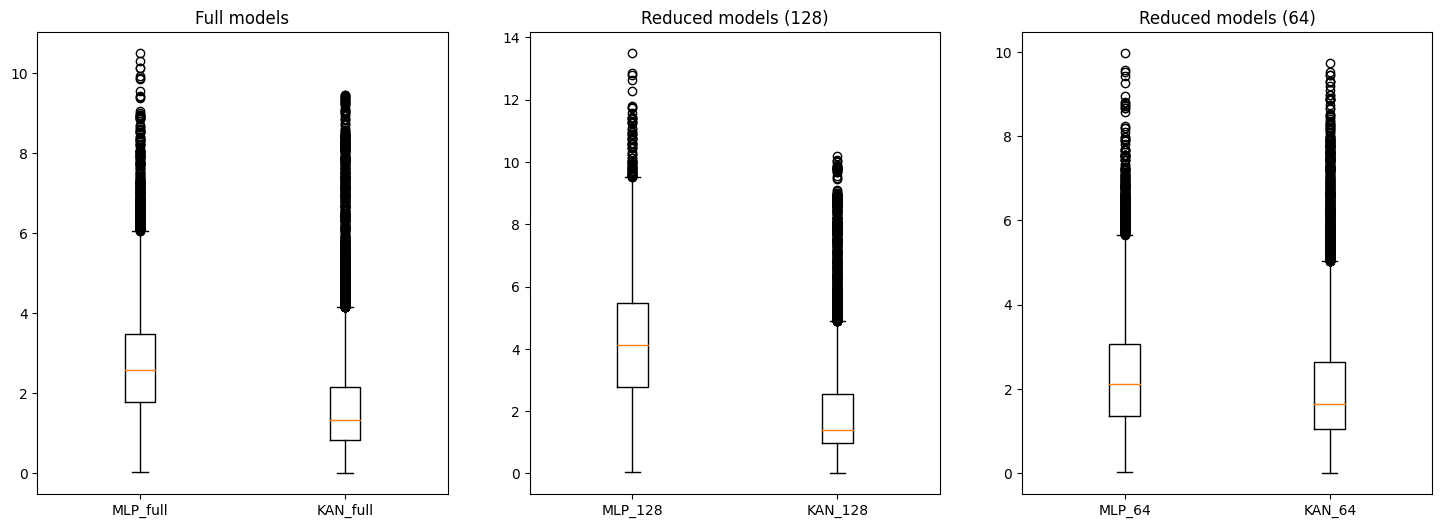

Statistics for  MLP_64
MLP_64: 25th percentile: 1.35 - 50th percentile: 2.12 - 75th percentile: 3.07 - Outliers: 310 (2.39%)
Mean: 2.34 - Max: 9.97
Max distance: 9.97
Statistics for  MLP_128
MLP_128: 25th percentile: 2.78 - 50th percentile: 4.12 - 75th percentile: 5.47 - Outliers: 76 (0.59%)
Mean: 4.17 - Max: 13.49
Max distance: 13.49
Statistics for  MLP_full
MLP_full: 25th percentile: 1.78 - 50th percentile: 2.58 - 75th percentile: 3.49 - Outliers: 309 (2.38%)
Mean: 2.74 - Max: 10.49
Max distance: 10.49
Statistics for  KAN_64
KAN_64: 25th percentile: 1.06 - 50th percentile: 1.64 - 75th percentile: 2.65 - Outliers: 523 (4.04%)
Mean: 2.01 - Max: 9.73
Max distance: 9.73
Statistics for  KAN_128
KAN_128: 25th percentile: 0.99 - 50th percentile: 1.38 - 75th percentile: 2.55 - Outliers: 796 (6.14%)
Mean: 1.97 - Max: 10.18
Max distance: 10.18
Statistics for  KAN_full
KAN_full: 25th percentile: 0.84 - 50th percentile: 1.34 - 75th percentile: 2.17 - Outliers: 792 (6.11%)
Mean: 1.74 - Max: 9.45


In [99]:
import matplotlib.pyplot as plt

if not perform_evaluation:
    print('Evaluation is disabled')
else:
    data = {
        'MLP_64': mlp_64_distances,
        'MLP_128': mlp_128_distances,
        'MLP_full': mlp_full_distances,
        'KAN_64': kan_64_distances,
        'KAN_128': kan_128_distances,
        'KAN_full': kan_full_distances
    }
    
    # Create boxplots for the results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].boxplot([data['MLP_full'], data['KAN_full']], labels=['MLP_full', 'KAN_full'])
    axes[0].set_title('Full models')
    
    axes[1].boxplot([data['MLP_128'], data['KAN_128']], labels=['MLP_128', 'KAN_128'])
    axes[1].set_title('Reduced models (128)')
    
    axes[2].boxplot([data['MLP_64'], data['KAN_64']], labels=['MLP_64', 'KAN_64'])
    axes[2].set_title('Reduced models (64)')
    
    plt.show()
    
    # Print model statistics: 25th, 50th (median), 75th percentiles, and the amount or percentage of outliers
    for key in data:
        print("====================================")
        print("Statistics for ", key)
        distances = data[key]
        q25, q50, q75 = np.percentile(distances, [25, 50, 75])
        iqr = q75 - q25
        lower_bound = q25 - 1.5 * iqr
        upper_bound = q75 + 1.5 * iqr
        outliers = np.sum((distances < lower_bound) | (distances > upper_bound))
        print(f'{key}: 25th percentile: {q25:.2f} - 50th percentile: {q50:.2f} - 75th percentile: {q75:.2f} - Outliers: {outliers} ({outliers/len(distances)*100:.2f}%)')
        print(f'Mean: {np.mean(distances):.2f} - Max: {np.max(distances):.2f}')
        
        # Print max predicted distance
        max_distance = np.max(distances)
        print(f'Max distance: {max_distance:.2f}')
        

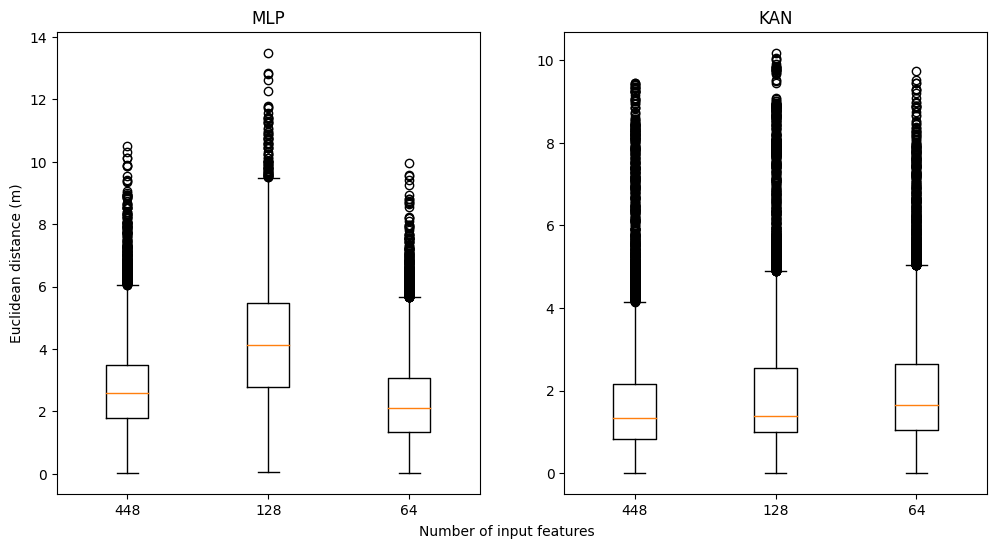

In [100]:
# Make a simiar plot as above, but now with just two subplots, one for MLP and one for KAN
if not perform_evaluation:
    print('Evaluation is disabled')
else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].boxplot([data['MLP_full'], data['MLP_128'], data['MLP_64']], labels=['448', '128', '64'])
    axes[0].set_title('MLP')
    
    axes[1].boxplot([data['KAN_full'], data['KAN_128'], data['KAN_64']], labels=['448', '128', '64'])
    axes[1].set_title('KAN')
    
    # y-label euclidean distance (m)
    axes[0].set_ylabel('Euclidean distance (m)')
    
    # x-axis label of entire plot
    fig.text(0.5, 0.04, 'Number of input features', ha='center')
    
    
    plt.show()